# Create ratings 3

From our first iteration of adding the song ratings, we got a dataset that had an amount of plays for every person for every song.

From our second iteration of adding the song ratings, we eliminated all 'listens' from profiles that had only listend to a song a single time. We also assigned a rating from 2-10 for every profile for every song based on the amount of plays that profile had per song.

Unfortunately, even with this reduction of data we still have too many items to perform matrix based methods of prediction.

We'll need to try again to get the data to a point where we can use it for matrix based methods.

We have the following goals for this notebook:

1. At this point we need to reduce the amount of items we have by a significant amount in order to use matrix factorization. We'd previously reduced our profiles to 2472 with 2205253 items.
I'd like to limit our songs to the top 1 million songs(items).

In [24]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive

In [25]:
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [26]:
listens=pd.read_csv('/drive/My Drive/Colab Notebooks/listen_table.csv')

In [27]:
listens.drop(columns=['Unnamed: 0'], inplace=True)
listens.head()

,user_name,song_no
0,Skeebadoo,0
1,Skeebadoo,1
2,Skeebadoo,2
3,Skeebadoo,3
4,Svarthjelm,4


In [28]:
# add one listen_no per profile listen
listens['listen_no'] = 1
listens = listens.groupby(["user_name","song_no"], sort=False, as_index=False).agg({"listen_no":"sum"})
listens.head()
# len(listens)

,user_name,song_no,listen_no
0,Skeebadoo,0,3
1,Skeebadoo,1,1
2,Skeebadoo,2,2
3,Skeebadoo,3,1
4,Svarthjelm,4,10


In [29]:
# Need to limit max song plays per profile to 10 to reduce impact of one person listening to almost 6k plays
print('max listens per profile before: '  + str(listens['listen_no'].max()))

# set max listens to 10
mask = listens['listen_no'] > 10
column_name = 'listen_no'
listens.loc[mask, column_name] = 10

print('max listens per profile after: '  + str(listens['listen_no'].max()))

max listens per profile before: 5874
max listens per profile after: 10


In [30]:
# number of unique songs
len(listens['song_no'].unique())

4660353

In [31]:
# save df with all songs
# will train final model with this if possible
# listens.to_csv('/drive/My Drive/Colab Notebooks/rated_listens_all.csv')

In [32]:
# new code for create_ratings3
# create new df with top 1 million songs

# create new song_list df
song_list = listens[['song_no', 'listen_no']]

# group song_list by song_no, agg listen_no
song_list = song_list.groupby(["song_no"], sort=True, as_index=False).agg({"listen_no":"sum"})

# sort by played amount(decending) and reset index
song_list = song_list.sort_values(['listen_no'], ascending=[False]).reset_index(drop=True)

song_list.head()

,song_no,listen_no
0,5538,2657
1,11453,2440
2,1200,2355
3,3026,2296
4,1071,2292


In [33]:
# limit songs to top 1M songs

song_list = song_list.iloc[:1000000]
len(song_list)

1000000

In [34]:
song_list.head()

,song_no,listen_no
0,5538,2657
1,11453,2440
2,1200,2355
3,3026,2296
4,1071,2292


In [35]:
# create list of top 1mil songs
top_songs = song_list['song_no'].tolist()
top_songs[:5]

[5538, 11453, 1200, 3026, 1071]

In [36]:
# Number of summed 'listens'
sum(listens['listen_no'])

29342067

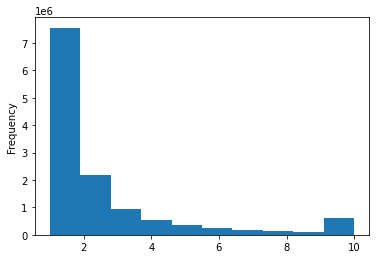

In [14]:
listens['listen_no'].plot.hist(bins=10)

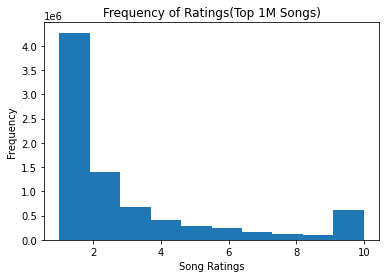

In [15]:
# filter listens to only include songs from the top 1mil songs
listens = listens[listens['song_no'].isin(top_songs)]
listens['listen_no'].plot.hist(bins=10)
plt.xlabel("Song Ratings")
plt.ylabel("Frequency")
plt.title("Frequency of Ratings(Top 1M Songs)");

In [16]:
# unique songs
len(listens['song_no'].unique())

1000000

In [17]:
# unique users
len(listens['user_name'].unique())

2598

In [18]:
listens2 = listens[listens['listen_no'] > 1]
# unique songs
len(listens2['song_no'].unique())

992338

In [19]:
# unique users
len(listens['user_name'].unique())

2598

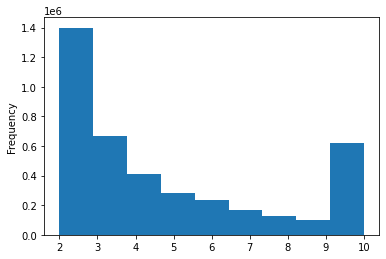

In [20]:
listens2['listen_no'].plot.hist(bins=9)

It looks like we don't gain or lose that much information by eliminating the profiles where a profile only listens to a song a single time.

We can include this valuable information for our model.

We'll again assign the rating for a song by the amount of plays the profile has on a given song.

We'll assign this rating and save it for modeling.

We'll go ahead and save the top 1M songs for reference as well.

In [21]:
listens = listens.rename({'listen_no': 'rating'}, axis=1)

In [22]:
listens['rating'].value_counts(normalize=True)

1     0.515505
2     0.168768
3     0.080817
10    0.074432
4     0.049775
5     0.034398
6     0.028590
7     0.020351
8     0.015564
9     0.011800
Name: rating, dtype: float64

Text(0.5, 1.0, 'Frequency of Ratings')

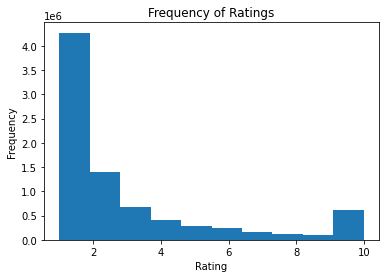

In [23]:
listens['rating'].plot.hist(bins=10)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Frequency of Ratings')

In [ ]:
listens.to_csv('/drive/My Drive/Colab Notebooks/rated_listens4.csv')

In [ ]:
song_list.to_csv('/drive/My Drive/Colab Notebooks/top_songs.csv')

We'll also create a df limited to only the top 10k songs for gridsearching.

In [ ]:
# create filter for top 10k songs
top_songs10k = top_songs[:10000]
len(top_songs10k)

10000

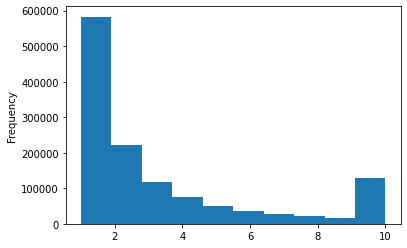

In [ ]:
# filter listens to only include songs from the top 10k songs
listens10k = listens[listens['song_no'].isin(top_songs10k)]
listens10k['rating'].plot.hist(bins=10)

In [ ]:
listens10k.head()

,user_name,song_no,rating
11,Svarthjelm,11,10
34,Svarthjelm,34,10
35,Svarthjelm,35,10
45,metabrew,45,2
47,metabrew,47,7


In [ ]:
len(listens10k)

1279949

In [ ]:
# unique users
len(listens10k['user_name'].unique())

2458

In [ ]:
# unique songs
len(listens10k['song_no'].unique())

10000

In [ ]:
listens10k.to_csv('/drive/My Drive/Colab Notebooks/rated_listens_10k.csv')

We'll also create a dataframe with the top 10k songs with an adjusted ratings scale to see if that performs better.

Rating Scale:
1. 1 play
2. 2-3 plays
3. 4-5 plays
4. 5-6 plays
5. 7+ plays

In [ ]:
listens10k['rating'].value_counts(normalize=True)

1     0.455352
2     0.174239
10    0.099719
3     0.091076
4     0.057912
5     0.039487
6     0.028944
7     0.022111
8     0.017323
9     0.013839
Name: rating, dtype: float64

In [ ]:
# baseline rating2 of 1
listens10k['rating2'] = 1

# Rating2 = 2 if 2 or 3 plays
listens10k.loc[(listens10k['rating'] == 2) |
             (listens10k['rating'] == 3), 'rating2'] = 2

# Rating2 = 3 if 3 or 4 plays
listens10k.loc[(listens10k['rating'] == 4) |
             (listens10k['rating'] == 5), 'rating2'] = 3

# Rating2 = 4 if 5 or 6 plays
listens10k.loc[(listens10k['rating'] == 6) |
             (listens10k['rating'] == 7), 'rating2'] = 4

# Rating2 = 5 if 7+ plays
listens10k.loc[(listens10k['rating'] > 7), 'rating2'] = 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
listens10k['rating2'].value_counts(normalize=True)

1    0.455352
2    0.265314
5    0.130880
3    0.097398
4    0.051055
Name: rating2, dtype: float64

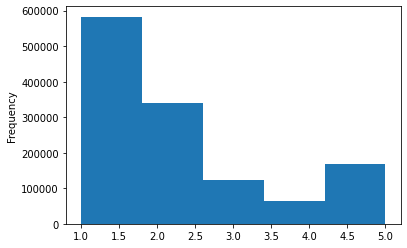

In [ ]:
listens10k['rating2'].plot.hist(bins=5)

In [ ]:
listens10k_aug = listens10k[['user_name', 'song_no', 'rating2']]

In [ ]:
# We'll save this one as well to test on to see if it's able to get better results
listens10k_aug.to_csv('/drive/My Drive/Colab Notebooks/rated_listens_10k_aug.csv')